<a href="https://www.kaggle.com/code/hijump/bogyo-eda-240108?scriptVersionId=158162849" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook parameters

In [2]:
debug = False
n_rows_debug = 100000

# Libraries

In [3]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
from itertools import product

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import math
import collections
import time
from copy import deepcopy
import seaborn as sns
import os, gc
from tqdm import tqdm
import re

pd.set_option('display.float_format', lambda x: '%.2f' % x) # No scientic notation

In [4]:
""" SCIKIT-LEARN """
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans


from collections import Counter, defaultdict

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import joblib


---
# Utils

In [5]:
def reduce_memory_usage(df, print_info=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    
    if print_info :
        print('*'*50)
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory before : {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    if print_info :
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory after  : {:.2f} MB'.format(end_mem))
        print('Decreased by  : {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('*'*50 + '\n')
    
    return df

---
# Definitions
* `county` - An ID code for the county (region).
* `is_business` - Boolean for whether or not the prosumer is a business.
* `product_type` - ID code with the following mapping of codes to contract types: `{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`.
* `is_consumption` - Boolean for whether or not this row's target is consumption or production.

<!-- Out target is consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type -->

# What do we need to predict?

For each county we need to make predicitons of consumption or production of electricity.
For each county we need to make prediction for several subgroups
`is_business(True/False)`, `is_consumption(True/False)`, `product_type(0, 1, 2, 3)`.

Let's call a combination of `county`, `is_business`, `is_consumption`, `product_type` as a segment.

We need to forecast each day at `11:00:00` (through the special API we get new available data each day, send forecasts).
Imagine that we at `2023-05-27 11:00:00`.

**Current time** <br>
`2023-05-27 11:00:00`
        
We need to predict for each hour and each segment next day <br>
`2023-05-28 00:00:00` <br>
`2023-05-28 01:00:00` <br>
`...` <br>
`2023-05-28 23:00:00`
        

        
At our current time we have acces to new additional data

**revealed_targets** (factual data for the previous day forecast) <br>
`2023-05-26 00:00:00` <br>
`2023-05-26 01:00:00` <br>
`...` <br>
`2023-05-26 23:00:00`
  

**client** (`installed_capacity`, `eic_count`) <br>
`2023-05-26`


**historical_weather** <br>
`2023-05-26 11:00:00` <br>
`2023-05-26 12:00:00` <br>
`...` <br>
`2023-05-27 10:00:00` <br>

        
**forecast_weather** (made at `2023-05-27 00:00:00`) <br>
`2023-05-27 01:00:00` <br>
`2023-05-27 02:00:00` <br>
`...` <br>
`2023-05-29 23:00:00`

        
**electricity_prices** <br>
`2023-05-27 00:00:00` <br>
`2023-05-27 01:00:00` <br>
`...` <br>
`2023-05-27 23:00:00` <br>

        
**gas_prices** <br>
`2023-05-27`
        
    
Of course we can use all data which was available before `2023-05-27 11:00:00` also.

        
Understanding the logic behind forecast process helps to create a correct dataset for training our models 
(without unavailale data at that point).


# Evaluation
Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:
$${\rm MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - x_i|, $$

Where: <br>
- $n$ is the total number of data points, <br>
- $y_i$ is the predicted value for data point $i$, <br>
- $x_i$ is the observed value for data point $i$.

---
# Data Check

In [17]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

train = pd.read_csv(os.path.join(root, "train.csv"))
client = pd.read_csv(os.path.join(root, "client.csv"))
gas = pd.read_csv(os.path.join(root, "gas_prices.csv"))
electricity = pd.read_csv(os.path.join(root, "electricity_prices.csv"))
forecast = pd.read_csv(os.path.join(root, "forecast_weather.csv"))
historical = pd.read_csv(os.path.join(root, "historical_weather.csv"))
weather_to_county_mapping = pd.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"))

## train.csv (2,018,352행)

- `county` - `county`의 ID 코드입니다.
    - ID 코드를 카운티 이름에 매핑하는 방법은 county_id_to_name_map.json`을 참조하세요.
- `is_business` - 프로슈머가 비즈니스인지 여부를 나타내는 Boolean 입니다.
- `product_type` - 다음과 같이 계약 유형에 코드가 매핑된 ID 코드입니다.
    - :`{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`.

---

- `target` - 해당 시간 동안의 해당 세그먼트에 대한 소비 또는 생산량입니다. 세그먼트는 다음과 같이 정의됩니다 `county`, `is_business`, and `product_type`.
- `prediction_unit_id` - 'county, is_business 및 product_type` 조합에 대한 고유 식별자입니다. 테스트 세트에 새로운 예측 단위가 나타나거나 사라질 수 있습니다.
    
    → (0 ~ 68) 보통 0 ~ 60에 분포하는데, 일부에서 61~68이 나오는 듯 하다.
    

---

- `is_consumption` - 이 행의 대상이 소비인지 생산인지에 대한 Boolean 입니다.
    - 0이면 생산, 1이면 소비

---

- `datetime` - 에스토니아 시간(Estonian time) in EET (UTC+2) / EEST (UTC+3)
    - 이미 주어진 데이터가 에스토니아 시간대에 맞춰져 있음
    - [21.09.01~23.06.01]

---

- `row_id` - 행의 고유 식별자입니다.
    - (0~2,018,351)
- `data_block_id` - 동일한 `data_block_id`를 공유하는 모든 행은 동일한 예측 시간에 사용할 수 있습니다. 이는 매일 오전 11시에 실제로 예보가 만들어질 때 어떤 정보를 사용할 수 있는지에 대한 함수입니다.
    - (0 ~ 637)
    - 2021-09-01 = 0
    - 2021-09-02 = 1

In [7]:
train

county  is_business  product_type  target  is_consumption  \
0             0            0             1    0.71               0   
1             0            0             1   96.59               1   
2             0            0             2    0.00               0   
3             0            0             2   17.31               1   
4             0            0             3    2.90               0   
...         ...          ...           ...     ...             ...   
2018347      15            1             0  197.23               1   
2018348      15            1             1    0.00               0   
2018349      15            1             1   28.40               1   
2018350      15            1             3    0.00               0   
2018351      15            1             3  196.24               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
0        2021-09-01 00:00:00              0        0                   0  
1        2021-09-01 00:00:00              0        1                   0  
2        2021-09-01 00:00:00              0        2                   1  
3        2021-09-01 00:00:00              0        3                   1  
4        2021-09-01 00:00:00              0        4                   2  
...                      ...            ...      ...                 ...  
2018347  2023-05-31 23:00:00            637  2018347                  64  
2018348  2023-05-31 23:00:00            637  2018348                  59  
2018349  2023-05-31 23:00:00            637  2018349                  59  
2018350  2023-05-31 23:00:00            637  2018350                  60  
2018351  2023-05-31 23:00:00            637  2018351                  60  

[2018352 rows x 9 columns]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

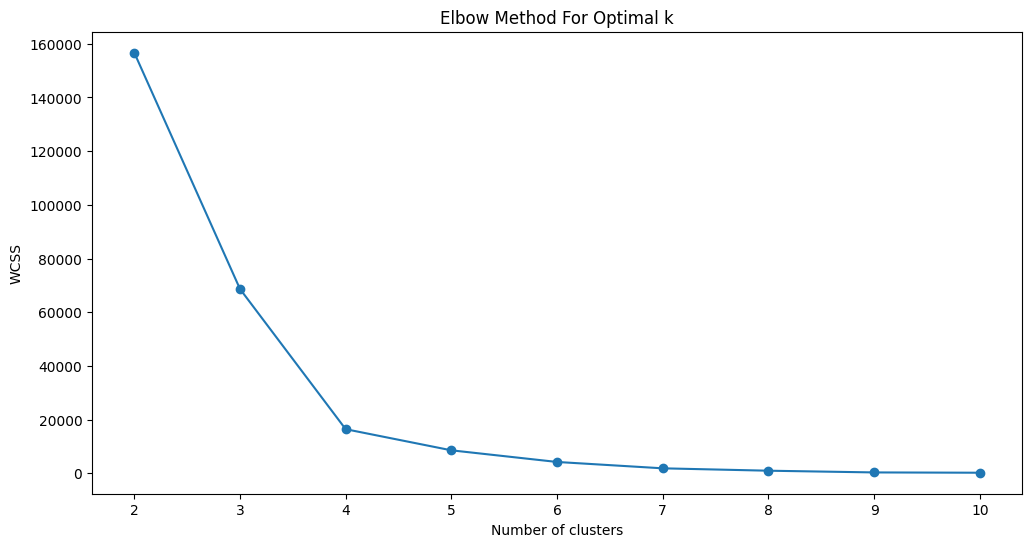

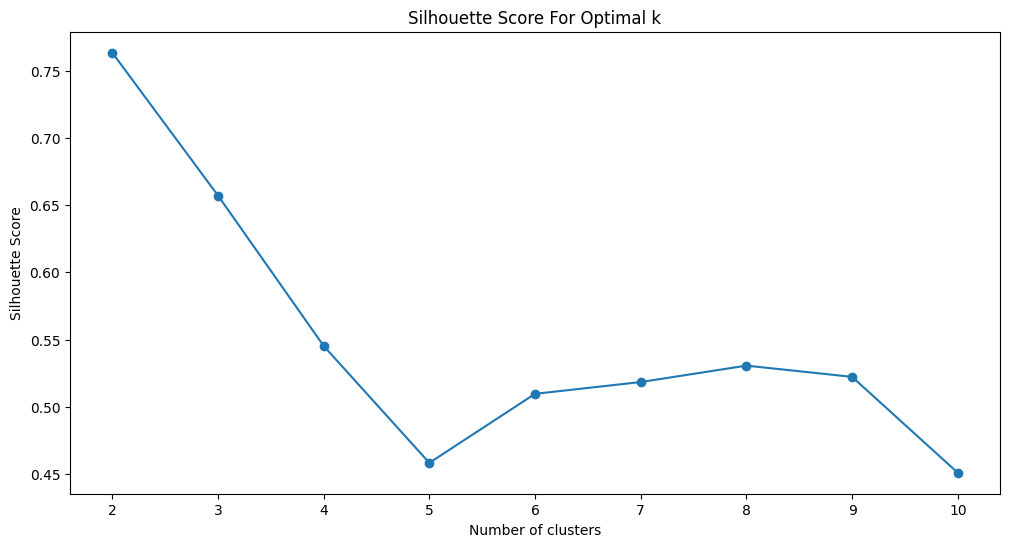

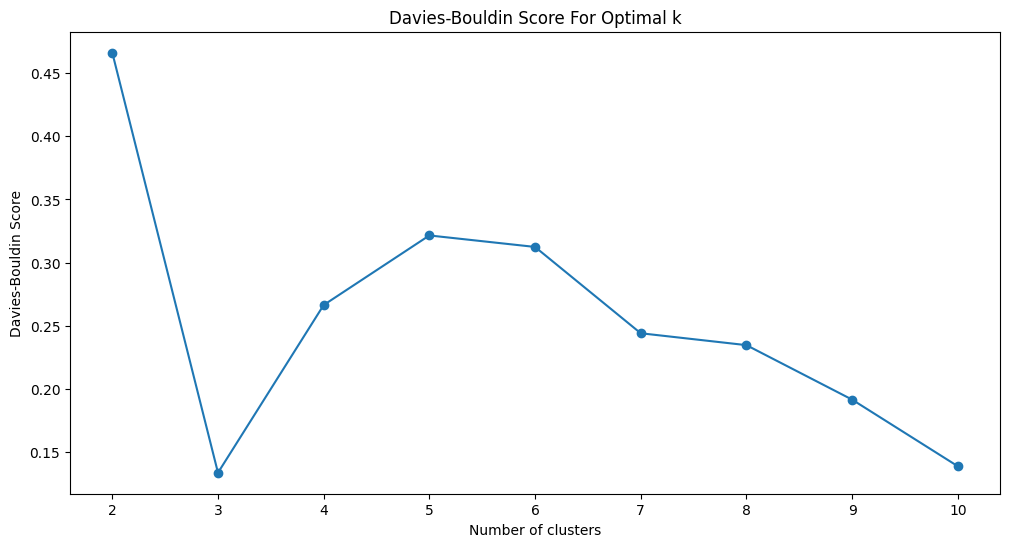

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# county별 target의 평균을 계산
county_features = train.groupby('county')['target'].mean().reset_index()

# 클러스터의 개수 범위 설정
range_n_clusters = list(range(2, 11))  # 2에서 10까지 클러스터 수를 고려

# 각 K에 대한 엘보우 방법, 실루엣 점수, Davies-Bouldin 점수를 저장할 리스트
elbow_method = []
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range_n_clusters:
    # KMeans 클러스터링 수행
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(county_features[['target']])
    
    # 클러스터 내 분산 (엘보우 방법)
    elbow_method.append(clusterer.inertia_)
    
    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(county_features[['target']], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Davies-Bouldin 점수 계산
    davies_bouldin_avg = davies_bouldin_score(county_features[['target']], cluster_labels)
    davies_bouldin_scores.append(davies_bouldin_avg)

# 엘보우 방법 시각화
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, elbow_method, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 실루엣 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Davies-Bouldin 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

In [39]:
# 클러스터 개수 3
features = train.groupby('county')['target'].mean().reset_index()

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
features['county_group'] = kmeans.fit_predict(features[['target']])

# 새로운 데이터프레임 생성: 기존 train 데이터프레임 복사
new_train = train.copy()

# 기존 데이터프레임에 클러스터 정보를 병합
new_train = new_train.merge(features[['county', 'county_group']], on='county', how='left')

new_train.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


county  is_business  product_type  target  is_consumption  \
0       0            0             1    0.71               0   
1       0            0             1   96.59               1   
2       0            0             2    0.00               0   
3       0            0             2   17.31               1   
4       0            0             3    2.90               0   

              datetime  data_block_id  row_id  prediction_unit_id  \
0  2021-09-01 00:00:00              0       0                   0   
1  2021-09-01 00:00:00              0       1                   0   
2  2021-09-01 00:00:00              0       2                   1   
3  2021-09-01 00:00:00              0       3                   1   
4  2021-09-01 00:00:00              0       4                   2   

   county_group  
0             2  
1             2  
2             2  
3             2  
4             2

In [40]:
# county_group 별로 그룹화
grouped = new_train.groupby('county_group')

# 각 그룹에 대한 정보 출력
for name, group in grouped:
    print(f'County Group: {name}')
    print('Counties in this group:', group['county'].unique())  # 이 그룹에 포함된 county 출력
    print('Number of entries in this group:', len(group))  # 이 그룹에 포함된 데이터의 개수
    print('\n')

County Group: 0
Counties in this group: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15]
Number of entries in this group: 1607424


County Group: 1
Counties in this group: [11]
Number of entries in this group: 198000


County Group: 2
Counties in this group: [0]
Number of entries in this group: 212928




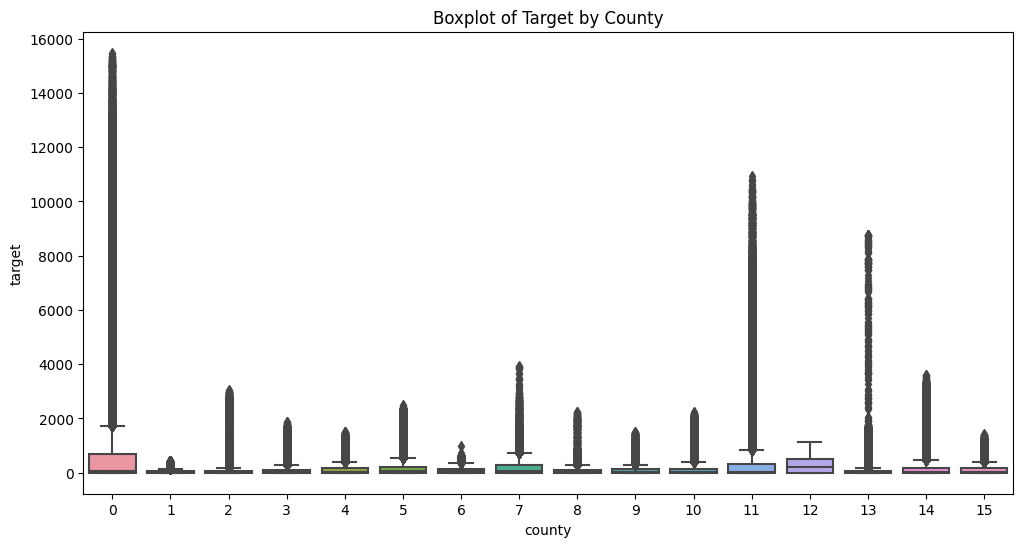

In [9]:
# 'county' 별로 'target'의 분포를 상자 그림으로 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='county', y='target', data=train)
plt.title('Boxplot of Target by County')
plt.show()

In [11]:
import scipy.stats as stats

# 각 county 범주별로 target 리스트를 생성하면서 결측치 제외
groups = train.dropna(subset=['target']).groupby('county')['target'].apply(list)

# ANOVA 테스트 수행
f_val, p_val = stats.f_oneway(*groups)

# 결과 출력
print('F-Statistic value:', f_val)
print('P-Value:', p_val)

F-Statistic value: 11911.605548842657
P-Value: 0.0


In [41]:
# county_group 별로 그룹화
grouped = new_train.groupby('county_group')

# 각 그룹에 대한 요약 통계 출력
for name, group in grouped:
    print(f'County Group: {name}')
    print(group['target'].describe())
    print('\n')

County Group: 0
count   1607004.00
mean        156.16
std         319.06
min           0.00
25%           0.34
50%          30.09
75%         144.69
max        8775.48
Name: target, dtype: float64


County Group: 1
count   197948.00
mean       521.78
std       1300.09
min          0.00
25%          0.33
50%         26.32
75%        339.64
max      10944.40
Name: target, dtype: float64


County Group: 2
count   212872.00
mean       941.33
std       2212.13
min          0.00
25%          0.73
50%         52.02
75%        685.06
max      15480.27
Name: target, dtype: float64




## train. 시각화

In [27]:
product_type = 3
is_business = 1 # 비즈니스
is_consumption = 1 # 소비


df_plot = train[
    (train['is_business'] == is_business)
    & (train['is_consumption'] == is_consumption)
    & (train['product_type'] == product_type)
]

# 특정 기간 설정
start_date = '2021-09-01'
end_date = '2022-09-30'

# 필터링된 데이터프레임 생성
df_filtered = df_plot[
    (df_plot['datetime'] >= start_date)
    & (df_plot['datetime'] <= end_date)
]


# 필터링된 데이터로 그래프 그리기
fig = px.line(
    df_filtered, 
    x="datetime", 
    y="target", 
    color='county', 
    title=f'Target for is_business={is_business}, is_consumption={is_consumption}, product_type={product_type} (From {start_date} to {end_date})'
)
fig.show()

In [18]:
train['datetime'].value_counts().to_frame().sort_index()

count
datetime                  
2021-09-01 00:00:00    122
2021-09-01 01:00:00    122
2021-09-01 02:00:00    122
2021-09-01 03:00:00    122
2021-09-01 04:00:00    122
...                    ...
2023-05-31 19:00:00    130
2023-05-31 20:00:00    130
2023-05-31 21:00:00    130
2023-05-31 22:00:00    130
2023-05-31 23:00:00    130

[15312 rows x 1 columns]

count
count 15312.00
mean    131.82
std       3.88
min     122.00
25%     130.00
50%     132.00
75%     134.00
max     138.00

array([[<Axes: title={'center': 'count'}>]], dtype=object)

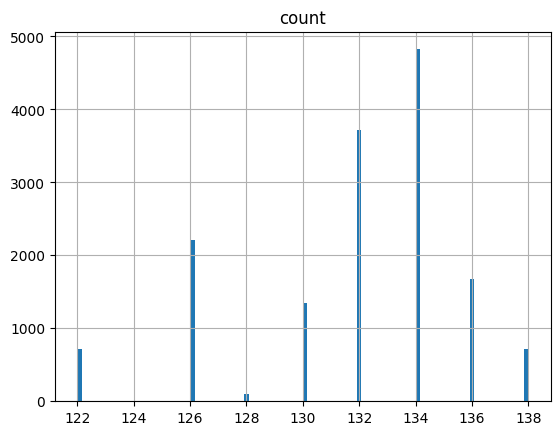

In [19]:
# datetime 빈도 확인
datetime_counts = train['datetime'].value_counts().to_frame().sort_index()
display(datetime_counts.describe())
datetime_counts.hist(bins=100)

## type 변경
- int -> categorical
    - county, is_business, product_type, is_consumption
- object -> datetime
    - datetime

# train.결측치 확인

In [9]:
train[train.isna().any(axis=1)]

county  is_business  product_type  target  is_consumption  \
178938        0            0             1     NaN               0   
178939        0            0             1     NaN               1   
178940        0            0             2     NaN               0   
178941        0            0             2     NaN               1   
178942        0            0             3     NaN               0   
...         ...          ...           ...     ...             ...   
1806379      15            1             0     NaN               1   
1806380      15            1             1     NaN               0   
1806381      15            1             1     NaN               1   
1806382      15            1             3     NaN               0   
1806383      15            1             3     NaN               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
178938   2021-10-31 03:00:00             60   178938                   0  
178939   2021-10-31 03:00:00             60   178939                   0  
178940   2021-10-31 03:00:00             60   178940                   1  
178941   2021-10-31 03:00:00             60   178941                   1  
178942   2021-10-31 03:00:00             60   178942                   2  
...                      ...            ...      ...                 ...  
1806379  2023-03-26 03:00:00            571  1806379                  64  
1806380  2023-03-26 03:00:00            571  1806380                  59  
1806381  2023-03-26 03:00:00            571  1806381                  59  
1806382  2023-03-26 03:00:00            571  1806382                  60  
1806383  2023-03-26 03:00:00            571  1806383                  60  

[528 rows x 9 columns]

datetime의 유형:  datetime64[ns]
----------------------------------------
Count of Missing Data:
hour
3    528
Name: count, dtype: int64
weekday
6    528
Name: count, dtype: int64
month
3     266
10    262
Name: count, dtype: int64
----------------------------------------


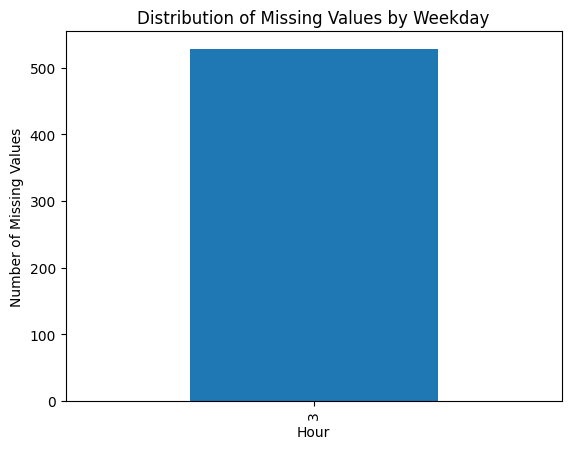

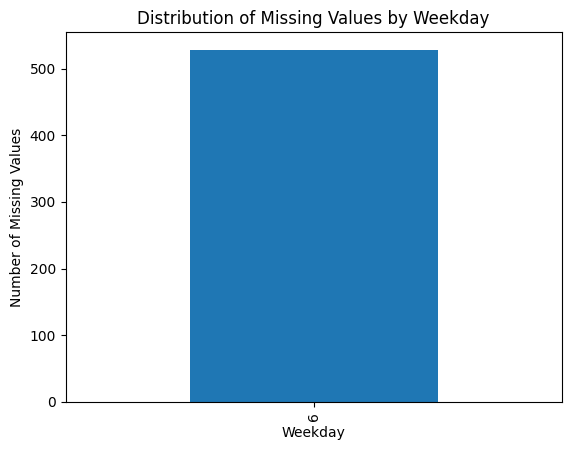

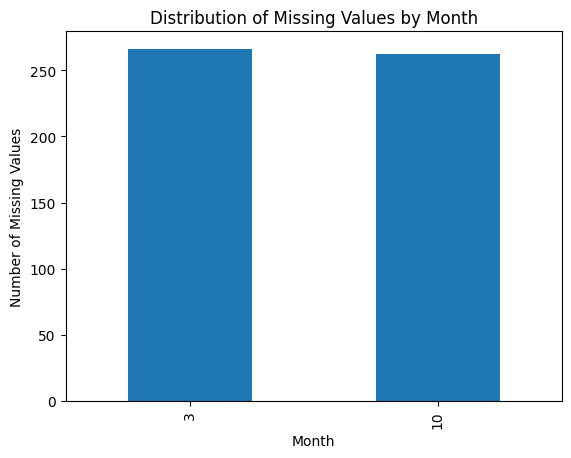

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 결측치가 있는 행들을 필터링합니다.
missing_data = train[train.isna().any(axis=1)].copy()

# 'datetime' 열을 datetime 객체로 변환합니다.
missing_data['datetime'] = pd.to_datetime(missing_data['datetime'])

# 변환된 데이터의 유형을 확인합니다.
print("datetime의 유형: ", missing_data['datetime'].dtype)

# 변환이 성공적으로 이루어졌는지 확인 후 datetime에서 파생 컬럼을 만들어 추가합니다.
if pd.api.types.is_datetime64_any_dtype(missing_data['datetime']):
    # 시간 관련 파생 변수를 한 번에 계산하여 추가합니다.
    datetime_attrs = ['year', 'month', 'day', 'hour', 'weekday']
    for attr in datetime_attrs:
        missing_data[attr] = getattr(missing_data['datetime'].dt, attr)
    
    # 추출한 속성에 대한 통계 출력
    print("-"*40)
    print("Count of Missing Data:")
    print(missing_data['hour'].value_counts())
    print(missing_data['weekday'].value_counts())
    print(missing_data['month'].value_counts())
    print("-"*40)
    
    # 시각화 함수 정의
    def plot_distribution(df, column, title):
        value_counts = df[column].value_counts().sort_index()
        value_counts.plot(kind='bar')
        plt.title(title)
        plt.xlabel(column.capitalize())
        plt.ylabel('Number of Missing Values')
        plt.show()
    
    # 시간별 결측치 분포 시각화
    plot_distribution(missing_data, 'hour', 'Distribution of Missing Values by Weekday')
    
    # 요일별 결측치 분포 시각화
    plot_distribution(missing_data, 'weekday', 'Distribution of Missing Values by Weekday')
    
    # 월별 결측치 분포 시각화
    plot_distribution(missing_data, 'month', 'Distribution of Missing Values by Month')

else:
    print("The 'datetime' column could not be converted to a datetime type.")


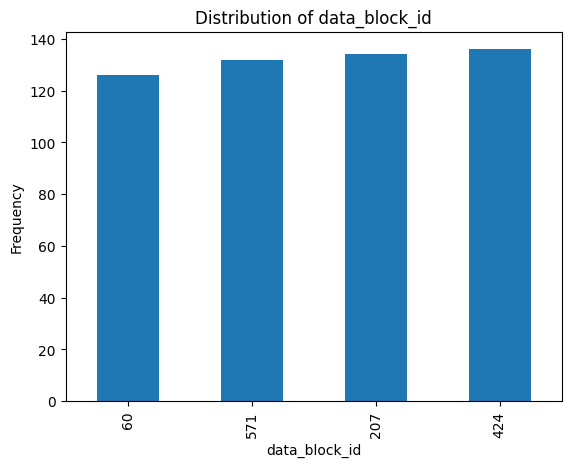

In [11]:
# 결측치 행의 data_block_id의 빈도수 계산
data_block_counts = missing_data['data_block_id'].value_counts().sort_values()

# 막대 그래프로 시각화
data_block_counts.plot(kind='bar')
plt.title('Distribution of data_block_id')
plt.xlabel('data_block_id')
plt.ylabel('Frequency')
plt.show()

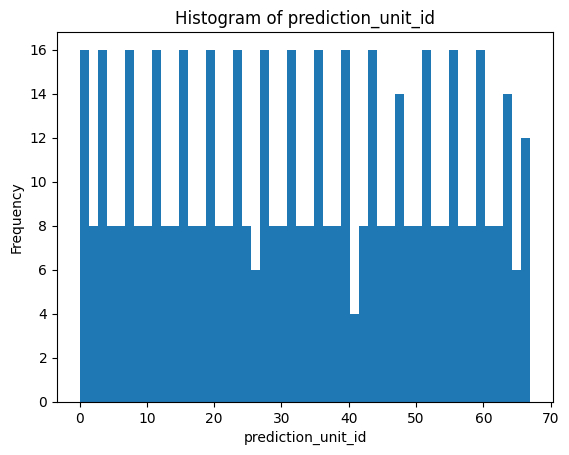

In [12]:
# 결측치 행의 prediction_unit_id의 빈도수 계산
missing_data['prediction_unit_id'].plot(kind='hist', bins=50)  # bins는 막대의 개수를 의미합니다.
plt.title('Histogram of prediction_unit_id')
plt.xlabel('prediction_unit_id')
plt.ylabel('Frequency')
plt.show()

---
## client.csv
- `product_type`
    - :`{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`
- `county`
- `eic_count` - 집계된 소비 포인트 수 (EICs - European Identifier Code).
- `installed_capacity` - 설치된 태양광 패널 용량(킬로와트).
- `is_business`
- `date`
- `data_block_id`

In [13]:
client

product_type  county  eic_count  installed_capacity  is_business  \
0                 1       0        108              952.89            0   
1                 2       0         17              166.40            0   
2                 3       0        688             7207.88            0   
3                 0       0          5              400.00            1   
4                 1       0         43             1411.00            1   
...             ...     ...        ...                 ...          ...   
41914             1      15         51              415.60            0   
41915             3      15        161             2035.75            0   
41916             0      15         15              620.00            1   
41917             1      15         20              624.50            1   
41918             3      15         55             2188.20            1   

             date  data_block_id  
0      2021-09-01              2  
1      2021-09-01              2  
2      2021-09-01              2  
3      2021-09-01              2  
4      2021-09-01              2  
...           ...            ...  
41914  2023-05-29            637  
41915  2023-05-29            637  
41916  2023-05-29            637  
41917  2023-05-29            637  
41918  2023-05-29            637  

[41919 rows x 7 columns]

In [14]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [15]:
client.describe()

product_type   county  eic_count  installed_capacity  is_business  \
count      41919.00 41919.00   41919.00            41919.00     41919.00   
mean           1.90     7.30      73.35             1450.77         0.54   
std            1.08     4.78     144.06             2422.23         0.50   
min            0.00     0.00       5.00                5.50         0.00   
25%            1.00     3.00      13.00              321.90         0.00   
50%            2.00     7.00      32.00              645.20         1.00   
75%            3.00    11.00      70.00             1567.15         1.00   
max            3.00    15.00    1517.00            19314.31         1.00   

       data_block_id  
count       41919.00  
mean          322.90  
std           182.08  
min             2.00  
25%           167.00  
50%           324.00  
75%           480.00  
max           637.00

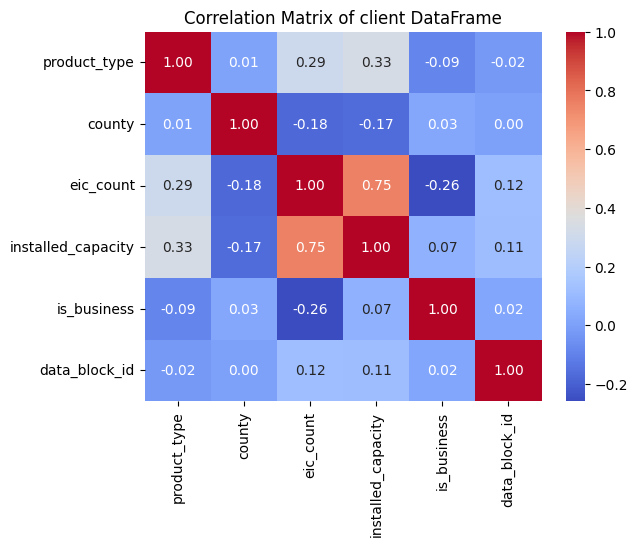

In [16]:
# client 데이터프레임의 상관관계 행렬 계산
correlation_matrix = client.corr(numeric_only=True)

# 상관관계 행렬 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of client DataFrame')
plt.show()

---
## gas_price.csv
- `origin_date` - 전날 가격 사용
    - [21.08.31~23.5.29]
- `forecast_date` - **예상 가격**이 관련되어야 하는 날짜
    - [21.09.01~23.5.30]
- `[lowest/highest]_price_per_mwh` - 해당 거래일 전일 시장에서 거래되는 천연가스의 최저/최고 가격 (메가와트시당 유로화 환산)입니다.
- `data_block_id`
    - (1~637)

In [40]:
gas

forecast_date  lowest_price_per_mwh  highest_price_per_mwh origin_date  \
0      2021-09-01                 45.23                  46.32  2021-08-31   
1      2021-09-02                 45.62                  46.29  2021-09-01   
2      2021-09-03                 45.85                  46.40  2021-09-02   
3      2021-09-04                 46.30                  46.80  2021-09-03   
4      2021-09-05                 46.30                  46.58  2021-09-04   
..            ...                   ...                    ...         ...   
632    2023-05-26                 29.10                  34.10  2023-05-25   
633    2023-05-27                 28.30                  34.10  2023-05-26   
634    2023-05-28                 28.10                  34.10  2023-05-27   
635    2023-05-29                 28.16                  36.98  2023-05-28   
636    2023-05-30                 29.00                  34.00  2023-05-29   

     data_block_id  avg_price  
0                1      45.77  
1                2      45.95  
2                3      46.12  
3                4      46.55  
4                5      46.44  
..             ...        ...  
632            633      31.60  
633            634      31.20  
634            635      31.10  
635            636      32.57  
636            637      31.50  

[637 rows x 6 columns]

In [41]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
 5   avg_price              637 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 30.0+ KB


#### gas에 가격 하나로 만들기

In [43]:
# gas_avg 만들기
gas['gas_price'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2

gas_avg = gas.drop(['lowest_price_per_mwh','highest_price_per_mwh'], axis=1)
gas_avg = gas_avg[['data_block_id', 'forecast_date', 'gas_price', 'origin_date']]
gas_avg

data_block_id forecast_date  gas_price origin_date
0                1    2021-09-01      45.77  2021-08-31
1                2    2021-09-02      45.95  2021-09-01
2                3    2021-09-03      46.12  2021-09-02
3                4    2021-09-04      46.55  2021-09-03
4                5    2021-09-05      46.44  2021-09-04
..             ...           ...        ...         ...
632            633    2023-05-26      31.60  2023-05-25
633            634    2023-05-27      31.20  2023-05-26
634            635    2023-05-28      31.10  2023-05-27
635            636    2023-05-29      32.57  2023-05-28
636            637    2023-05-30      31.50  2023-05-29

[637 rows x 4 columns]

---
## electricity_prices.csv
- 가스와 달리 전기는 1시간 마다 가격이 찍힘
- `origin_date`
- `forecast_date`
- `euros_per_mwh` - 다음 날의 전력 가격은 메가와트시당 유로로 표시됩니다.
- `data_block_id`

In [37]:
electricity

forecast_date  euros_per_mwh          origin_date  data_block_id
0      2021-09-01 00:00:00          92.51  2021-08-31 00:00:00              1
1      2021-09-01 01:00:00          88.90  2021-08-31 01:00:00              1
2      2021-09-01 02:00:00          87.35  2021-08-31 02:00:00              1
3      2021-09-01 03:00:00          86.88  2021-08-31 03:00:00              1
4      2021-09-01 04:00:00          88.43  2021-08-31 04:00:00              1
...                    ...            ...                  ...            ...
15281  2023-05-30 19:00:00          82.10  2023-05-29 19:00:00            637
15282  2023-05-30 20:00:00         150.85  2023-05-29 20:00:00            637
15283  2023-05-30 21:00:00          82.10  2023-05-29 21:00:00            637
15284  2023-05-30 22:00:00          82.09  2023-05-29 22:00:00            637
15285  2023-05-30 23:00:00          -1.29  2023-05-29 23:00:00            637

[15286 rows x 4 columns]

In [49]:
15286/24

636.9166666666666

In [64]:
electricity['data_block_id'].value_counts()

data_block_id
1      24
428    24
421    24
422    24
423    24
       ..
215    24
216    24
637    24
208    23
572    23
Name: count, Length: 637, dtype: int64

In [38]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [46]:
electricity.rename(columns={'euros_per_mwh':'elec_price'}, inplace=True)
electricity = electricity[['data_block_id', 'forecast_date', 'elec_price', 'origin_date']]
electricity

data_block_id        forecast_date  elec_price          origin_date
0                  1  2021-09-01 00:00:00       92.51  2021-08-31 00:00:00
1                  1  2021-09-01 01:00:00       88.90  2021-08-31 01:00:00
2                  1  2021-09-01 02:00:00       87.35  2021-08-31 02:00:00
3                  1  2021-09-01 03:00:00       86.88  2021-08-31 03:00:00
4                  1  2021-09-01 04:00:00       88.43  2021-08-31 04:00:00
...              ...                  ...         ...                  ...
15281            637  2023-05-30 19:00:00       82.10  2023-05-29 19:00:00
15282            637  2023-05-30 20:00:00      150.85  2023-05-29 20:00:00
15283            637  2023-05-30 21:00:00       82.10  2023-05-29 21:00:00
15284            637  2023-05-30 22:00:00       82.09  2023-05-29 22:00:00
15285            637  2023-05-30 23:00:00       -1.29  2023-05-29 23:00:00

[15286 rows x 4 columns]

---
# forecast_weather.csv
예측 시점에 사용할 수 있었던 일기 예보입니다. 다음으로 부터 가져온 자료입니다. [유럽 중기 예보 센터](https://codes.ecmwf.int/grib/param-db/?filter=grib2).

- `[latitude/longitude]` - 일기 예보의 좌표입니다
- `origin_datetime` - 예측이 생성된 시점의 타임스탬프입니다.
- `hours_ahead` - 예보 생성과 예보 날씨 사이의 시간 수입니다. 각 예보는 총 48시간 동안 적용됩니다.
- `temperature` - 지상 2m 지점의 대기 온도를 섭씨 단위로 표시합니다.
- `dewpoint` - 지상 2m 지점에서의 이슬점 온도를 섭씨 단위로 표시합니다.
- `cloudcover_[low/mid/high/total]` - 다음 고도 구간에서 구름으로 덮인 하늘의 비율입니다: 0-2, 2-6, 6+ 및 합계.
- `10_metre_[u/v]_wind_component` - 풍속의 [동쪽/북쪽] 성분은 지표면 10미터 상공에서 측정한 풍속을 초당 미터 단위로 표시합니다.
- `forecast_datetime` - 예상 날씨의 타임스탬프입니다. `origin_datetime`에 `hours_ahead`을 더하여 생성됩니다.
- `direct_solar_radiation` - 태양의 방향에 수직인 평면에서 지표면에 도달한 직사광선이 이전 시간 동안 누적된 것으로, 평방미터당 와트시 단위입니다.
- `surface_solar_radiation_downwards` - 지구 표면의 수평면에 도달하는 직접 및 확산 태양 복사열을 평방미터당 와트시 단위로 나타낸 값입니다.
- `snowfall` - 지난 한 시간 동안의 적설량(미터 환산) 단위입니다.
- `total_precipitation` - 이전 한 시간 동안 지구 표면에 내린 비와 눈으로 구성된 축적된 액체를 미터 단위로 표시합니다.
- `data_block_id`

In [31]:
forecast

latitude  longitude      origin_datetime  hours_ahead  temperature  \
0           57.60      21.70  2021-09-01 02:00:00            1        15.66   
1           57.60      22.20  2021-09-01 02:00:00            1        13.00   
2           57.60      22.70  2021-09-01 02:00:00            1        14.21   
3           57.60      23.20  2021-09-01 02:00:00            1        14.84   
4           57.60      23.70  2021-09-01 02:00:00            1        15.29   
...           ...        ...                  ...          ...          ...   
3424507     59.70      26.20  2023-05-30 02:00:00           48        10.15   
3424508     59.70      26.70  2023-05-30 02:00:00           48        10.26   
3424509     59.70      27.20  2023-05-30 02:00:00           48        10.47   
3424510     59.70      27.70  2023-05-30 02:00:00           48        10.69   
3424511     59.70      28.20  2023-05-30 02:00:00           48        11.23   

         dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
0           11.55             0.90            0.02            0.00   
1           10.69             0.89            0.00            0.00   
2           11.67             0.73            0.01            0.00   
3           12.26             0.34            0.07            0.00   
4           12.46             0.10            0.09            0.00   
...           ...              ...             ...             ...   
3424507      5.66             0.06            0.26            0.00   
3424508      5.92             0.11            0.90            0.20   
3424509      6.07             0.00            0.39            0.45   
3424510      7.01             0.00            0.51            1.00   
3424511      7.07             0.70            0.29            0.93   

         cloudcover_total  10_metre_u_wind_component  \
0                    0.91                      -0.41   
1                    0.89                       0.21   
2                    0.73                       1.45   
3                    0.39                       1.09   
4                    0.18                       1.27   
...                   ...                        ...   
3424507              0.31                       6.89   
3424508              0.91                       6.89   
3424509              0.53                       6.21   
3424510              1.00                       5.81   
3424511              0.99                       2.72   

         10_metre_v_wind_component  data_block_id    forecast_datetime  \
0                            -9.11              1  2021-09-01 03:00:00   
1                            -5.36              1  2021-09-01 03:00:00   
2                            -7.42              1  2021-09-01 03:00:00   
3                            -9.16              1  2021-09-01 03:00:00   
4                            -8.98              1  2021-09-01 03:00:00   
...                            ...            ...                  ...   
3424507                      -3.26            637  2023-06-01 02:00:00   
3424508                      -3.77            637  2023-06-01 02:00:00   
3424509                      -4.70            637  2023-06-01 02:00:00   
3424510                      -4.34            637  2023-06-01 02:00:00   
3424511                      -0.92            637  2023-06-01 02:00:00   

         direct_solar_radiation  surface_solar_radiation_downwards  snowfall  \
0                          0.00                               0.00      0.00   
1                          0.00                               0.00      0.00   
2                          0.00                               0.00      0.00   
3                          0.00                               0.00      0.00   
4                          0.00                               0.00      0.00   
...                         ...                                ...       ...   
3424507                    0.00                               0.00      0.00   
3424508          

In [32]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [34]:
forecast.isna().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

In [ ]:
# client 데이터프레임의 상관관계 행렬 계산
correlation_matrix = forecast.corr(numeric_only=True)

# 상관관계 행렬 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of forecast DataFrame')
plt.show()

---
# 전처리 예시

- 아래 코드는 나중에 참고하려고 넣어둠.

In [20]:
def preTrain(data, client, hist_weather, forecast_weather, electricity, gas, locations):

    # 타겟값이 없는 행 제거
    data = data[data['target'].notnull()] 
    
    # 'datetime' 열을 datetime 타입으로 변환
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    
    # 'forecast_date' 열 이름을 'datetime'으로 변경해서 추후에 train 데이터와 병합하기 위함
    electricity = electricity.rename(columns={'forecast_date' : 'datetime'})
    
    # 'datetime' 열을 datetime 타입으로 변환
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc=True)
    
    # client 데이터의 'data_block_id'를 2 감소시킴 (train 데이터와 맞추기 위함)
    client['data_block_id'] -= 2
      
    # 'locations'는 좌표를 군단위로 변환하는데 사용됨
    locations = locations.drop('Unnamed: 0', axis=1) 
        
    # 위도와 경도를 소수 첫째자리까지 반올림
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
    
    # 'locations' 데이터의 군단위 정보와 'forecast_weather' 데이터의 좌표 정보를 병합
    forecast_weather = forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
    
    # 결측치 제거
    forecast_weather.dropna(axis=0, inplace=True)    
    
    # 'county' 열을 정수형으로 변환
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    # 사용하지 않을 열 제거
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace=True)
    
    # 'forecast_datetime' 열 이름을 'datetime'으로 변경
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    
    # 'datetime' 열을 datetime 타입으로 변환
    forecast_weather['datetime'] = pd.to_datetime(forecast_weather['datetime'], utc=True)
    
    # 시간별로 'forecast_weather' 열의 평균값 계산
    forecast_weather_datetime = forecast_weather.groupby([forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    
    # 'datetime' 열을 다시 datetime 타입으로 변환
    forecast_weather_datetime['datetime'] = pd.to_datetime(forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    # 시간별, 군단위로 'forecast_weather' 열의 평균값 계산
    forecast_weather_datetime_county = forecast_weather.groupby(['county', forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    
    # 'datetime' 열을 다시 datetime 타입으로 변환
    forecast_weather_datetime_county['datetime'] = pd.to_datetime(forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    # 위도와 경도를 소수 첫째자리까지 반올림 (역사적 날씨 데이터에 적용)
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)
    
    # 'locations' 데이터와 'hist_weather' 데이터 병합
    hist_weather = hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    # 결측치 제거
    hist_weather.dropna(axis=0, inplace=True)
    
    # 사용하지 않을 열 제거
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 'county' 열을 정수형으로 변환
    hist_weather['county'] = hist_weather['county'].astype('int64')
    
    # 'datetime' 열을 datetime 타입으로 변환
    hist_weather['datetime'] = pd.to_datetime(hist_weather['datetime'], utc=True)
    
    # 시간별로 'hist_weather' 열의 평균값 계산
    hist_weather_datetime = hist_weather.groupby([hist_weather['datetime'].dt.to_period('h')])[list(hist_weather.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()    
    
    # 'datetime' 열을 다시 datetime 타입으로 변환
    hist_weather_datetime['datetime'] = pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    # 'hist_weather' 데이터와 'data_block_id' 병합
    hist_weather_datetime = hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 시간별, 군단위로 'hist_weather' 열의 평균값 계산
    hist_weather_datetime_county = hist_weather.groupby(['county', hist_weather['datetime'].dt.to_period('h')])[list(hist_weather.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index() 
    
    # 'datetime' 열을 다시 datetime 타입으로 변환
    hist_weather_datetime_county['datetime'] = pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    
    # 'hist_weather' 데이터와 'data_block_id' 병합
    hist_weather_datetime_county = hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')

    # 'data'에 연, 월, 일, 시간, 요일, 연중 일수 추가
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['dayofweek'] = data['datetime'].dt.dayofweek
    data['dayofyear'] = data['datetime'].dt.dayofyear

    # 전력 데이터에 시간 열 추가
    electricity['hour'] = electricity['datetime'].dt.hour

    # 'data'와 다른 데이터들 병합
    data = data.merge(client.drop(columns=['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    data = data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    data = data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    data = data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    data = data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'], suffixes=('_fcast_mean', '_fcast_mean_by_county'))

    # 'hist_weather' 데이터와 'data' 병합을 위해 시간 열 추가
    hist_weather_datetime['hour'] = hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour'] = hist_weather_datetime_county['datetime'].dt.hour

    # 중복 및 필요 없는 'datetime' 열 제거
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis=1, inplace=True)
    hist_weather_datetime_county.drop('datetime', axis=1, inplace=True)

    # 'hist_weather' 데이터와 'data' 병합
    data = data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])
    data = data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes=('_hist_mean', '_hist_mean_by_county'))

    # 결측치를 해당 시간의 평균값으로 채움
    data = data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    # 필요 없는 데이터 제거
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis=1, inplace=True)
    
    return data

In [21]:
def create_df(df, client, historical_weather, forecast_weather,
              electricity_prices, gas_prices, sample_prediction) :
    """다양한 데이터 소스로부터 특성을 병합하여 데이터프레임을 생성하는 함수"""

    #################################################
    # ⚡ 전기 가격 특성 ⚡
    #################################################

    # 전기 가격 정보를 기본 데이터프레임과 병합
    df = pd.merge(df,
                  electricity_prices[["time", "euros_per_mwh"]],
                  how='left',
                  on=["time"],
                 )

    #################################################
    # 🛢️ 가스 가격 특성 🛢️
    #################################################

    # 가스 가격 정보를 기본 데이터프레임과 병합
    cols = ['time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
    df = df.merge(gas_prices[cols],
                 how='left',
                 on=["time"],
                 )

    #################################################
    # 🧑 클라이언트 특성 🧑
    #################################################
   
    # 클라이언트 정보를 기본 데이터프레임과 병합
    df = df.merge(client.drop(columns=['datetime', 'date', 'time']),
                 how='left',
                 on=['county', 'is_business', 'product_type'],
                 )

    #################################################
    # 🌤️ 역사적 기상 특성 🌤️
    #################################################
    
    # 위도/경도 기반 정보 집계를 위한 설정
    dict_agg = {
        'temperature' : ['min', 'mean', 'max', 'std'],
        # (다른 기상 변수에 대한 집계 설정)
    }

    # 군단위 및 시간별로 역사적 기상 데이터 집계
    keys = ['county', 'datetime']
    historical_weather = historical_weather.groupby(keys).agg(dict_agg).reset_index()

    # 열 이름 평탄화
    historical_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in historical_weather.columns]
    historical_weather.columns = [x + '_h' if x not in keys else x for x in historical_weather.columns]

    # 시간 이동 적용
    historical_weather['datetime'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)
    
    # 역사적 기상 정보를 기본 데이터프레임과 병합
    df = df.merge(historical_weather,
                  how='left',
                  on=['county', 'datetime'],
                 )
    
    #################################################
    # 🌤️ 예보 기상 특성 🌤️
    #################################################
    
    # 시간별 정보 집계를 위한 설정
    dict_agg = {
        'temperature' : ['min', 'mean', 'max', 'std'],
        # (다른 예보 기상 변수에 대한 집계 설정)
    }

    # 군단위 및 예보 날짜별로 예보 기상 데이터 집계
    keys = ['county', 'forecast_datetime']
    forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

    # 열 이름 평탄화
    forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
    forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

    # 예보 기상 정보를 기본 데이터프레임과 병합
    df = df.merge(forecast_weather.rename(columns={'forecast_datetime': 'datetime'}),
                  how='left',
                  on=['county', 'datetime'],
                 )

    # 결측치 처리
    df = df.sort_values(by=['datetime']).reset_index(drop=True)
    for k in df :
        if k.endswith('_f') :
            df[k] = df[k].ffill().bfill()
    
    #################################################
    # ⚙️ 최종 처리 ⚙️
    #################################################
    
    # 데이터 정렬 및 결측치 0으로 채우기
    df.fillna(0, inplace=True)

    # 처리된 데이터프레임 반환
    return df
